In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['figure.facecolor'] = 'white'

In [24]:
df_hist = pd.read_csv('rating_histories.csv', engine='c')

In [25]:
df_hist.head()

,contestId,contestName,handle,newRating,oldRating,rank,ratingUpdateTimeSeconds
0,2,Codeforces Beta Round #2,tourist,1602,1500,14,1267124400
1,8,Codeforces Beta Round #8,tourist,1764,1602,5,1270748700
2,10,Codeforces Beta Round #10,tourist,1878,1764,18,1271353500
3,13,Codeforces Beta Round #13,tourist,1967,1878,11,1273161600
4,19,Codeforces Beta Round #19,tourist,2063,1967,2,1277398800


In [13]:
df_hist.shape

(155290, 7)

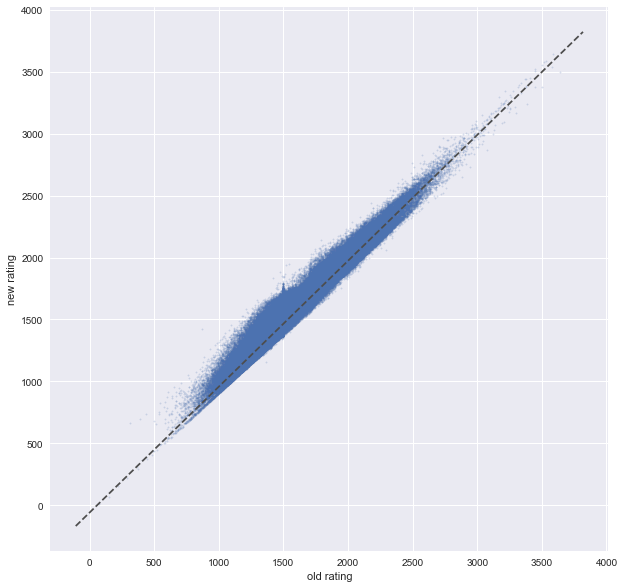

In [20]:
# old rating is highly correlated to new rating over all users
plt.scatter(df_hist.oldRating, df_hist.newRating, alpha=.2, s=2)
ax = plt.gca()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('old rating')
plt.ylabel('new rating')

In [39]:
g_hist = df_hist.groupby(df_hist.handle)
autocor = []
for k, v in g_hist:
    #v.sort_values('ratingUpdateTimeSeconds', inplace=True)
    autocor.append(v.newRating.autocorr())

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


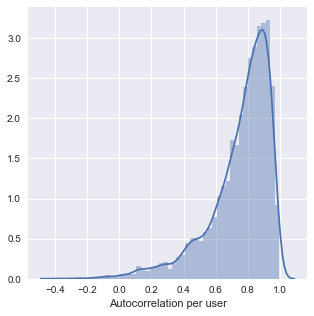

In [43]:
sns.distplot(autocor)
plt.xlabel('Autocorrelation per user')

In [64]:
maxchange = g_hist.newRating.aggregate(lambda x: x.values[-1]) - g_hist.newRating.aggregate(lambda x: x.values[0]) 
maxchange.sort_values(inplace=True)
maxchange

handle
Hedgehogy             -1391
mr.baraa               -891
asad_IT                -865
niranjanMaisnam        -860
DivideAndConquer       -766
Fake_Death             -715
errorerror             -701
the_badcoder           -678
Only_Me                -672
m_borhan               -668
vagabond               -667
sabbiracm14            -651
basma_essam            -642
Sanan07                -631
-ML-                   -621
Dalai                  -620
asiuzzaman006          -610
azzammohamed923        -608
ronyripon              -607
Tanvir_Anzum           -597
Sakhawat_CoU           -594
Ifat.JUST              -593
Minato_Yellow_Flash    -590
saurav.1432            -589
youssef01001           -587
RolandoHCH             -586
mohamedveron23         -585
del-0-R                -581
johir_sec              -577
travelers              -573
                       ... 
Endagorion             1174
al13n                  1179
ainta                  1188
Kostroma               1189
enot.1.10    

# Which handles are missing?
Note that some users don't have any contest ratings. We probably can't do much for them. There are a total of 660 of such users.

In [69]:
## get handles
#with open('all_handles.txt') as f:
#    allHandles = [line.strip() for line in f.readlines()]

df_tmp = pd.read_csv('rating_histories.csv', engine='c')
handles_have = set(df_tmp.handle.values)

In [70]:
handles_need = set([])
with open('all_submissions.tsv') as f:
    print f.readline()
    for line in f.readlines():
        handles_need.add(line.split('\t')[0])

author	contestID	id	language	memoryBytes	participantType	passedTestCount	points	problem_index	problem_name	problem_tags	relativeTimeSeconds	startTimeSeconds	testset	timeMilliseconds	verdict



In [71]:
print len(handles_have)
print len(handles_need)

58422
56696


In [72]:
missing = handles_need.difference(handles_have)
print len(missing)
with open('missing_handles.txt', 'w') as f:
    for m in missing:
        f.write(m + '\n')

1116


In [5]:
verdicts = set([])
with open('all_submissions.tsv') as f:
    print f.readline()
    for line in f.readlines():
        verdicts.add(line.split('\t')[-1])

author	contestID	id	language	memoryBytes	participantType	passedTestCount	points	problem_index	problem_name	problem_tags	relativeTimeSeconds	startTimeSeconds	testset	timeMilliseconds	verdict



In [6]:
verdicts

{'CHALLENGED\n',
 'COMPILATION_ERROR\n',
 'CRASHED\n',
 'FAILED\n',
 'IDLENESS_LIMIT_EXCEEDED\n',
 'MEMORY_LIMIT_EXCEEDED\n',
 'OK\n',
 'PARTIAL\n',
 'PRESENTATION_ERROR\n',
 'REJECTED\n',
 'RUNTIME_ERROR\n',
 'SKIPPED\n',
 'TESTING\n',
 'TIME_LIMIT_EXCEEDED\n',
 'WRONG_ANSWER\n'}

# Insert hack attempts into SQL database

In [4]:
from sqlalchemy import *
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

dbname = 'codeforces'
username = 'Joy'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://Joy@localhost/codeforces
True


## Contest information
get contests, only need to run once

In [22]:
# create table with schema
metadata = MetaData()
#index	creationTimeSeconds	id	verdict	ghost	defender	hacker	contestID	problemID	problemName
contests = Table('contests', metadata,
    Column('id', Integer, primary_key=True),
    Column('durationSeconds', Integer, nullable=False),
    Column('relativeTimeSeconds', Integer),
    Column('startTimeSeconds', Integer),
    Column('frozen', Boolean),
    Column('name', String),
    Column('type', String),
    Column('phase', String)
)
contests.drop(engine, checkfirst=True)
contests.create(engine)

url = 'http://codeforces.com/api/contest.list?gym=false'
r = requests.get(url).json()['result']
df_contests = pd.DataFrame.from_dict(r)
#df_contests.to_csv('contests.tsv', sep='\t', index=False, header=True, encoding='utf')
df_contests.to_sql('contests', engine, if_exists='replace')

## Get information on hacks

In [24]:
import requests
from time import sleep
def getContestHacks(contest):
    url = 'http://codeforces.com/api/contest.hacks?contestId=' + str(contest)
    print url
    maxtries = 5
    tries = 0
    while tries < maxtries:
        print "attempt", tries
        try:
            r = requests.get(url).json()
            if r['status'] == 'FAILED':
                print r['comment']
                return
            r = r['result']
            if len(r) > 0:
                return pd.DataFrame.from_dict(r)
            else:
                return
        except:
            print "error, attempt", tries
            tries += 1
            sleep(5)
    print "ERROR GETTING HACK INFO FOR CONTEST", contest

### Create table schema for hacks

In [29]:
# create table with schema
metadata = MetaData()
#index	creationTimeSeconds	id	verdict	ghost	defender	hacker	contestID	problemID	problemName
hacks = Table('hacks', metadata,
    Column('id', Integer, primary_key=True),
    Column('creationTimeSeconds', Integer, nullable=False),
    Column('verdict', String),
    Column('ghost', Boolean),
    Column('defender', String),
    Column('hacker', String),
    Column('contestID', String),
    Column('problemID', String),
    Column('problemName', String)
)
hacks.drop(engine, checkfirst=True)
hacks.create(engine)

### request information on hacks

In [74]:
contest_ids = df_contests.id
last_idx = 443

for i, cid in enumerate(contest_ids[last_idx:]):
    print last_idx + i, cid
    df_hack = getContestHacks(cid)
    
    if df_hack is None:
        continue
    
    # format resulting dataframe
    ghost = df_hack.defender.apply(lambda x: x['ghost'])
    defender = df_hack.defender.apply(lambda x: x['members'][0]['handle'])
    hacker = df_hack.hacker.apply(lambda x: x['members'][0]['handle'])
    contestID = df_hack.problem.apply(lambda x: x['contestId'])
    problemID = df_hack.problem.apply(lambda x: x['index'])
    problemName = df_hack.problem.apply(lambda x: x['name'])
    
    df_hack.drop(['defender', 'hacker', 'judgeProtocol', 'problem', 'test'], inplace=True, axis=1)
    df_hack['ghost'] = ghost
    df_hack['defender'] = defender
    df_hack['hacker'] = hacker
    df_hack['contestID'] = contestID
    df_hack['problemID'] = problemID
    df_hack['problemName'] = problemName
    
    print "writing to sql..."
    df_hack.to_sql('hacks', engine, if_exists='append', index=False)

443 350
http://codeforces.com/api/contest.hacks?contestId=350
attempt 0
writing to sql...
444 348
http://codeforces.com/api/contest.hacks?contestId=348
attempt 0
writing to sql...
445 349
http://codeforces.com/api/contest.hacks?contestId=349
attempt 0
writing to sql...
446 346
http://codeforces.com/api/contest.hacks?contestId=346
attempt 0
writing to sql...
447 347
http://codeforces.com/api/contest.hacks?contestId=347
attempt 0
writing to sql...
448 343
http://codeforces.com/api/contest.hacks?contestId=343
attempt 0
writing to sql...
449 344
http://codeforces.com/api/contest.hacks?contestId=344
attempt 0
writing to sql...
450 345
http://codeforces.com/api/contest.hacks?contestId=345
attempt 0
451 342
http://codeforces.com/api/contest.hacks?contestId=342
attempt 0
writing to sql...
452 340
http://codeforces.com/api/contest.hacks?contestId=340
attempt 0
writing to sql...
453 341
http://codeforces.com/api/contest.hacks?contestId=341
attempt 0
writing to sql...
454 339
http://codeforces.co

writing to sql...
536 255
http://codeforces.com/api/contest.hacks?contestId=255
attempt 0
writing to sql...
537 254
http://codeforces.com/api/contest.hacks?contestId=254
attempt 0
writing to sql...
538 253
http://codeforces.com/api/contest.hacks?contestId=253
attempt 0
writing to sql...
539 251
http://codeforces.com/api/contest.hacks?contestId=251
attempt 0
writing to sql...
540 252
http://codeforces.com/api/contest.hacks?contestId=252
attempt 0
writing to sql...
541 250
http://codeforces.com/api/contest.hacks?contestId=250
attempt 0
writing to sql...
542 247
http://codeforces.com/api/contest.hacks?contestId=247
attempt 0
543 248
http://codeforces.com/api/contest.hacks?contestId=248
attempt 0
writing to sql...
544 249
http://codeforces.com/api/contest.hacks?contestId=249
attempt 0
writing to sql...
545 246
http://codeforces.com/api/contest.hacks?contestId=246
attempt 0
writing to sql...
546 245
http://codeforces.com/api/contest.hacks?contestId=245
attempt 0
547 243
http://codeforces.co

631 156
http://codeforces.com/api/contest.hacks?contestId=156
attempt 0
writing to sql...
632 157
http://codeforces.com/api/contest.hacks?contestId=157
attempt 0
writing to sql...
633 154
http://codeforces.com/api/contest.hacks?contestId=154
attempt 0
writing to sql...
634 155
http://codeforces.com/api/contest.hacks?contestId=155
attempt 0
writing to sql...
635 153
http://codeforces.com/api/contest.hacks?contestId=153
attempt 0
636 152
http://codeforces.com/api/contest.hacks?contestId=152
attempt 0
writing to sql...
637 150
http://codeforces.com/api/contest.hacks?contestId=150
attempt 0
writing to sql...
638 151
http://codeforces.com/api/contest.hacks?contestId=151
attempt 0
writing to sql...
639 149
http://codeforces.com/api/contest.hacks?contestId=149
attempt 0
writing to sql...
640 148
http://codeforces.com/api/contest.hacks?contestId=148
attempt 0
writing to sql...
641 145
http://codeforces.com/api/contest.hacks?contestId=145
attempt 0
writing to sql...
642 146
http://codeforces.co

writing to sql...
725 62
http://codeforces.com/api/contest.hacks?contestId=62
attempt 0
writing to sql...
726 61
http://codeforces.com/api/contest.hacks?contestId=61
attempt 0
writing to sql...
727 64
http://codeforces.com/api/contest.hacks?contestId=64
attempt 0
728 60
http://codeforces.com/api/contest.hacks?contestId=60
attempt 0
writing to sql...
729 59
http://codeforces.com/api/contest.hacks?contestId=59
attempt 0
writing to sql...
730 58
http://codeforces.com/api/contest.hacks?contestId=58
attempt 0
writing to sql...
731 57
http://codeforces.com/api/contest.hacks?contestId=57
attempt 0
writing to sql...
732 56
http://codeforces.com/api/contest.hacks?contestId=56
attempt 0
writing to sql...
733 55
http://codeforces.com/api/contest.hacks?contestId=55
attempt 0
writing to sql...
734 54
http://codeforces.com/api/contest.hacks?contestId=54
attempt 0
writing to sql...
735 53
http://codeforces.com/api/contest.hacks?contestId=53
attempt 0
writing to sql...
736 52
http://codeforces.com/api

## Test connection

In [89]:
# connect:
con = psycopg2.connect(database = dbname, user = username)
cur = con.cursor()

###  show all tables

In [90]:
#cur.execute("""SELECT datname from pg_database""")
#cur.execute("""SELECT * FROM pg_catalog.pg_tables""")
#cur.execute("""
#DROP TABLE IF EXISTS hack;
#    """)
cur.execute("""
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
    """)
rows = cur.fetchall()
for r in rows:
    print r

('public.contests',)
('public.hacks',)
('public.problem_info',)
('public.problem_rating',)


In [79]:
# query:
sql_query = """
SELECT * FROM hacks WHERE verdict='HACK_SUCCESSFUL';
"""
df_hack = pd.read_sql_query(sql_query,con)

In [91]:
con.commit()
con.close()